In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [24]:
import subprocess

sequential_folder = "./data/Sequential"
mpi_folder = "./data/MPI" 
omp_folder = "./data/OpenMP"
mpi_openmp_folder = "./data/MPI+OpenMP"

csv_name = "/joinedData.csv"
join_data_script = "/joinData.py"

# Execute the joinData.py script from the forlders inside the data folder
# to generate the data.csv file
subprocess.run(["python3", sequential_folder + join_data_script], check=True)
subprocess.run(["python3", mpi_folder + join_data_script], check=True)
subprocess.run(["python3", omp_folder + join_data_script], check=True)
subprocess.run(["python3", mpi_openmp_folder + join_data_script], check=True)


[OK] OpenMP data joined successfully
[OK] MPI data joined successfully
[OK] OpenMP data joined successfully
[OK] MPI + OpenMP data joined successfully


CompletedProcess(args=['python3', './data/MPI+OpenMP/joinData.py'], returncode=0)

In [25]:
sequential_data = pd.read_csv(sequential_folder + csv_name)
mpi_data = pd.read_csv(mpi_folder + csv_name)
openmp_data = pd.read_csv(omp_folder + csv_name)
mpi_openmp_data = pd.read_csv(mpi_openmp_folder + csv_name)

In [98]:
def show_accumulative_plot(data, title, horizontal=False):
    partial_columns = [
        'ReadGray(s)', 'ReadColor(s)', 'Gray(s)', 'Hsl(s)', 'Yuv(s)', 
        'WriteGray(s)', 'WriteHsl(s)', 'WriteYuv(s)'
    ]

    data_partial = data[partial_columns]

    # Add the Rest (s) column, with min value o 0
    data_partial['Rest(s)'] = (data['Total(s)'] - data_partial.sum(axis=1)).clip(lower=0)

    # Transpose for plotting
    data_for_plot = data_partial
    labels = partial_columns + ['Rest(s)']

    # Create the stacked bar plot

    plt.figure(figsize=(5, 5))

    print(len(labels))

    if horizontal:
        ax = data_for_plot.plot(kind='barh', stacked=True, figsize=(12, len(labels)*0.6), colormap='viridis')
        plt.xlabel('Seconds', fontsize=12)
        plt.ylabel('Configuration', fontsize=12)
        plt.yticks(ticks=range(len(data)), labels=data['Label'])
    else:
        ax = data_for_plot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
        plt.ylabel('Seconds', fontsize=12)
        plt.xlabel('Configuration', fontsize=12)
        plt.xticks(ticks=range(len(data)), labels=data['Label'], rotation=45)

    # Customize the plot
    plt.title(title or 'Accumulative Bar Chart of the 5 Best Times', fontsize=16)
    plt.legend(labels, title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Add total time at the top of each bar
    for i, total in enumerate(data['Total(s)']):
        if horizontal:
            ax.text(total, i, f'{total:.2f}', ha='left', va='center')
        else:
            ax.text(i, total, f'{total:.2f}', ha='center', va='bottom')

    # Show the plot
    plt.show()


def show_bar_plot (labels, data, title, horizontal=False):
    # Plot the bar chart horizontally
    plt.figure(figsize=(12, 6))
    bars = plt.barh(labels, data)
    plt.ylabel('Configuration')
    plt.xlabel('Total Time (s)')
    plt.title(title or 'Total Time of the 5 Best Configurations', fontsize=16)

    # Add the value in each bar
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                 va='center', ha='left', fontsize=10)

    plt.tight_layout()
    plt.show()

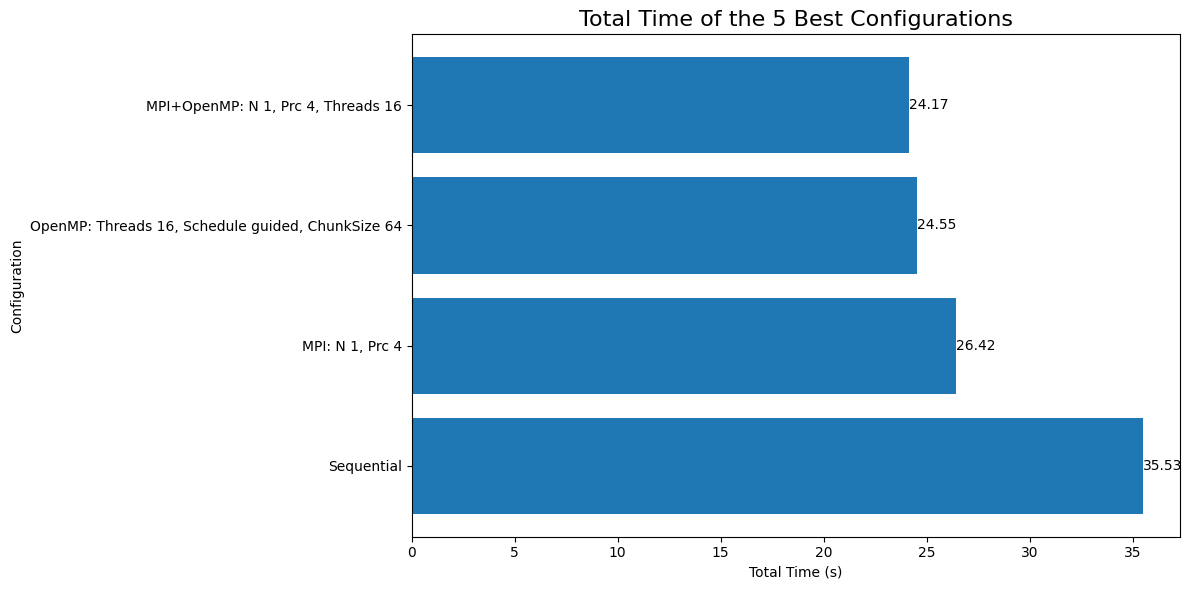

In [69]:
num_top_times = 1

# Extract the best times from openmp_data
best_openmp_times = openmp_data.nsmallest(num_top_times, 'Total(s)')

# Extract the best times from mpi_data
best_mpi_times = mpi_data.nsmallest(num_top_times, 'Total(s)')

# Extract the best times from mpi_openmp_data
best_mpi_openmp_times = mpi_openmp_data.nsmallest(num_top_times, 'Total(s)')

# Mix the best times from mpi, openmp and mpi+openmp
best_times = pd.concat([best_mpi_times, best_openmp_times, best_mpi_openmp_times, sequential_data], ignore_index=True)

# Order in descending order
best_times = best_times.sort_values(by='Total(s)', ascending=False)

show_bar_plot(best_times['Label'], best_times['Total(s)'], 'Total Time of the 5 Best Configurations', horizontal=True)



9


/tmp/ipykernel_974/1344126837.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_partial['Rest(s)'] = (data['Total(s)'] - data_partial.sum(axis=1)).clip(lower=0)


<Figure size 500x500 with 0 Axes>

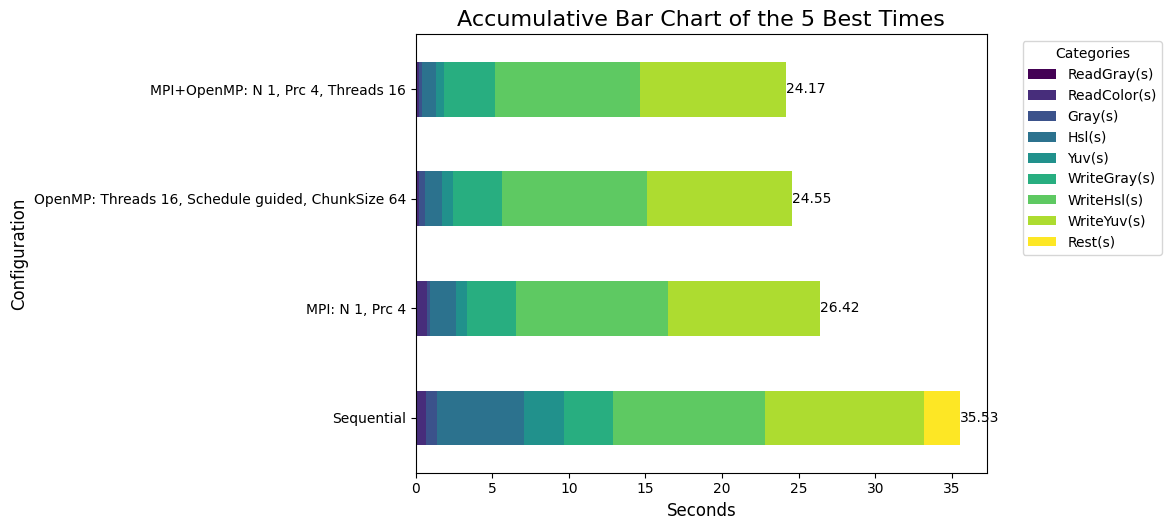

In [99]:
show_accumulative_plot(best_times, 'Accumulative Bar Chart of the 5 Best Times', True)

9


/tmp/ipykernel_974/3267683149.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_partial['Rest(s)'] = (data['Total(s)'] - data_partial.sum(axis=1)).clip(lower=0)
/tmp/ipykernel_974/3267683149.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 500x500 with 0 Axes>

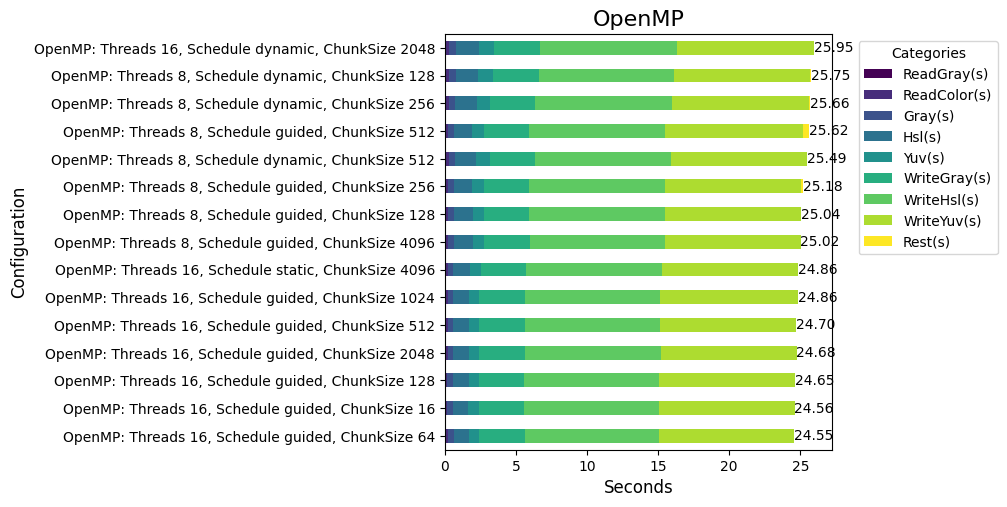

/tmp/ipykernel_974/3267683149.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_partial['Rest(s)'] = (data['Total(s)'] - data_partial.sum(axis=1)).clip(lower=0)


9


<Figure size 500x500 with 0 Axes>

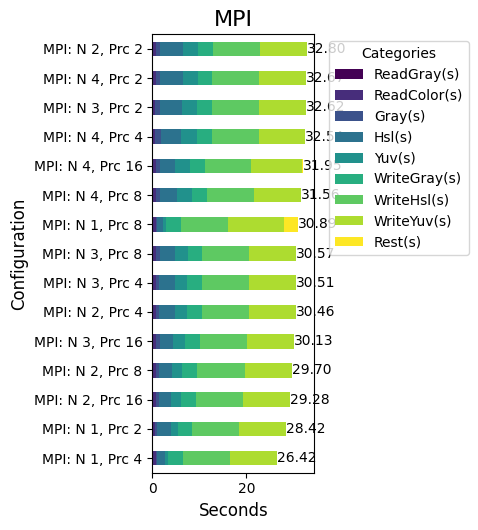

/tmp/ipykernel_974/3267683149.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_partial['Rest(s)'] = (data['Total(s)'] - data_partial.sum(axis=1)).clip(lower=0)


9


<Figure size 500x500 with 0 Axes>

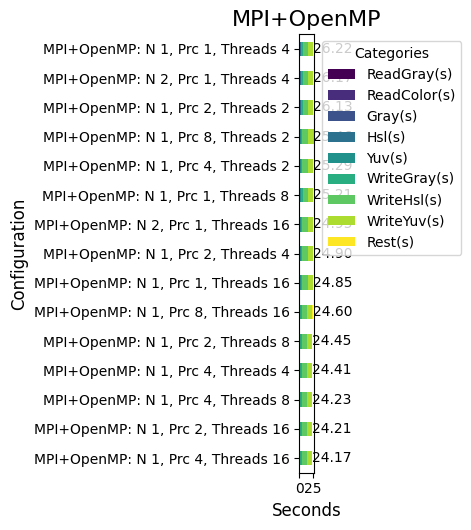

In [97]:
# Por cada implementación, hacer un diagrama de barras acumulativo con los mejores 5 tiempos en cada caso, donde en las barras
# se muestre de forma acumulada la suma de cada uno de los tiempos, y encima el valor del tiempo total

data_per_graph = 15

# Extract the best times from openmp_data
best_openmp_times = openmp_data.nsmallest(data_per_graph, 'Total(s)')
best_openmp_times = best_openmp_times.sort_values(by='Total(s)', ascending=True)

# Extract the best times from mpi_data
best_mpi_times = mpi_data.nsmallest(data_per_graph, 'Total(s)')
best_mpi_times = best_mpi_times.sort_values(by='Total(s)', ascending=True)

# Extract the best times from mpi_openmp_data
best_mpi_openmp_times = mpi_openmp_data.nsmallest(data_per_graph, 'Total(s)')
best_mpi_openmp_times = best_mpi_openmp_times.sort_values(by='Total(s)', ascending=True)



show_accumulative_plot(best_openmp_times, 'OpenMP', True)
show_accumulative_plot(best_mpi_times, 'MPI', True)
show_accumulative_plot(best_mpi_openmp_times, 'MPI+OpenMP', True)